## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-05 22:37:22.833 | INFO     |  Running on cpu


In [3]:
task = 'BlockTablePink'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-05 22:37:27.294 | INFO     |  Loading dataset(s): 
2025-08-05 22:37:27.295 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockTablePink/demos/metadata.json
2025-08-05 22:37:27.298 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-05 22:37:27.298 | INFO     |    Extracted tsdf object labels []
2025-08-05 22:37:27.298 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([142, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([142]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([142, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([142, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([142, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([142, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=20,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    min_end_distance=20,
    #velocity_threshold=0.002,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 22:37:37.518 | INFO     |  Fitting AutoTPGMM
2025-08-05 22:37:37.519 | INFO     |  Performing fitting actions: [INIT]
2025-08-05 22:37:37.519 | INFO     |  Segmenting trajectories


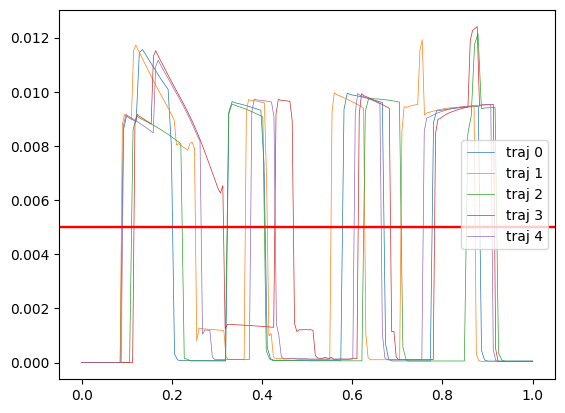

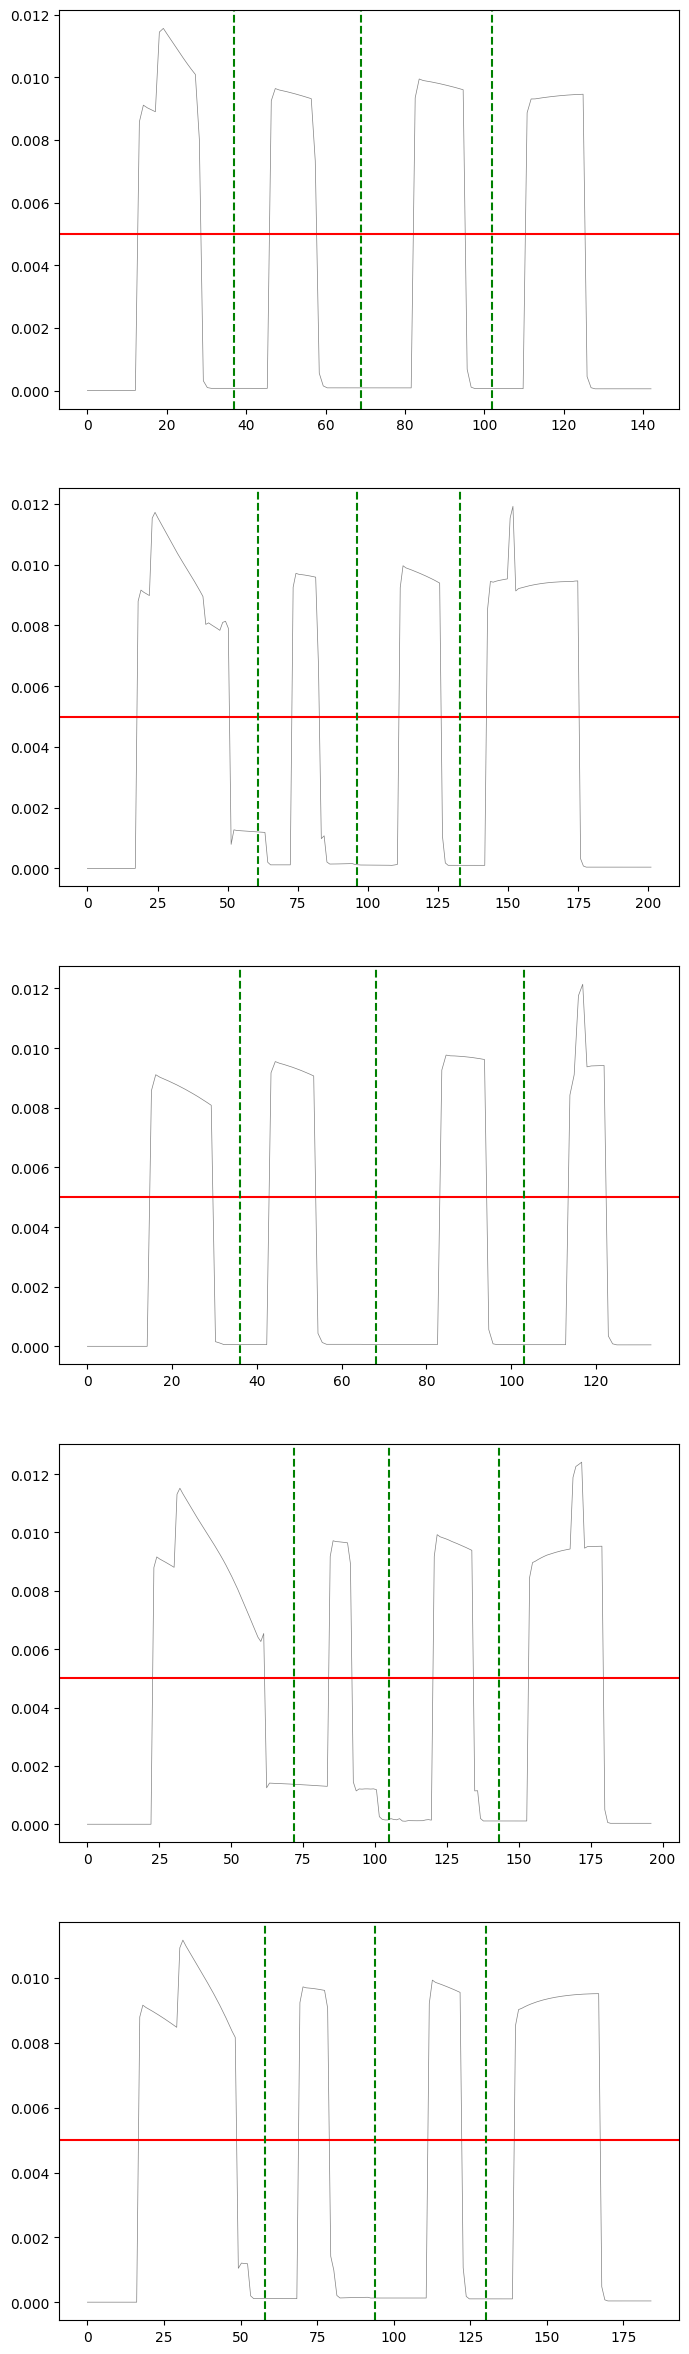

2025-08-05 22:37:39.202 | INFO     |  Creating segement of demos.
2025-08-05 22:37:39.215 | INFO     |  Subsampling to length 61 using strategy mean-length.
2025-08-05 22:37:39.216 | INFO     |  Creating segement of demos.
2025-08-05 22:37:39.228 | INFO     |  Subsampling to length 42 using strategy mean-length.
2025-08-05 22:37:39.229 | INFO     |  Creating segement of demos.
2025-08-05 22:37:39.239 | INFO     |  Subsampling to length 44 using strategy mean-length.
2025-08-05 22:37:39.241 | INFO     |  Creating segement of demos.
2025-08-05 22:37:39.251 | INFO     |  Subsampling to length 58 using strategy mean-length.
2025-08-05 22:37:39.253 | INFO     |  ... created 4 segments
2025-08-05 22:37:39.253 | INFO     |    Fitting candidate frame 1/10
2025-08-05 22:37:39.253 | INFO     |    Creating partial frame view of demos.
2025-08-05 22:37:39.263 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-05 22:37:39.263 | INFO     |    Changing number of components to 5
2025-08-05 22:37:

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:39.877 | INFO     |    Fitting candidate frame 2/10
2025-08-05 22:37:39.877 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:40.368 | INFO     |    Fitting candidate frame 3/10
2025-08-05 22:37:40.368 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:40.911 | INFO     |    Fitting candidate frame 4/10
2025-08-05 22:37:40.911 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:41.531 | INFO     |    Fitting candidate frame 5/10
2025-08-05 22:37:41.532 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:42.111 | INFO     |    Fitting candidate frame 6/10
2025-08-05 22:37:42.112 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:42.477 | INFO     |    Fitting candidate frame 7/10
2025-08-05 22:37:42.477 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:42.917 | INFO     |    Fitting candidate frame 8/10
2025-08-05 22:37:42.918 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:43.307 | INFO     |    Fitting candidate frame 9/10
2025-08-05 22:37:43.308 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:43.681 | INFO     |    Fitting candidate frame 10/10
2025-08-05 22:37:43.682 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:37:44.097 | INFO     |  ee_init    score (rel):     -0 (0.180)
2025-08-05 22:37:44.097 | INFO     |  obj000     score (rel):     -0 (0.180)
2025-08-05 22:37:44.098 | INFO     |  obj001     score (rel):     -0 (0.180)
2025-08-05 22:37:44.098 | INFO     |  obj002     score (rel):     -0 (0.180)
2025-08-05 22:37:44.098 | INFO     |  obj003     score (rel):     -0 (0.180)
2025-08-05 22:37:44.098 | INFO     |  obj004     score (rel):     -0 (0.180)
2025-08-05 22:37:44.098 | INFO     |  obj005     score (rel):     -0 (0.180)
2025-08-05 22:37:44.098 | INFO     |  obj006     score (rel):     -0 (0.002)
2025-08-05 22:37:44.098 | INFO     |  obj007     score (rel):     -0 (0.002)
2025-08-05 22:37:44.098 | INFO     |  obj008     score (rel):     -1 (1.000)
2025-08-05 22:37:44.099 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:37:44.101 | INFO     |    Fitting candidate frame 1/10
2025-08-05 22:37:44.101 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:44.489 | INFO     |    Fitting candidate frame 2/10
2025-08-05 22:37:44.489 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:44.971 | INFO     |    Fitting candidate frame 3/10
2025-08-05 22:37:44.971 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:45.185 | INFO     |    Fitting candidate frame 4/10
2025-08-05 22:37:45.185 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:45.398 | INFO     |    Fitting candidate frame 5/10
2025-08-05 22:37:45.398 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:45.625 | INFO     |    Fitting candidate frame 6/10
2025-08-05 22:37:45.626 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:45.828 | INFO     |    Fitting candidate frame 7/10
2025-08-05 22:37:45.829 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:46.110 | INFO     |    Fitting candidate frame 8/10
2025-08-05 22:37:46.111 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:46.453 | INFO     |    Fitting candidate frame 9/10
2025-08-05 22:37:46.453 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:46.727 | INFO     |    Fitting candidate frame 10/10
2025-08-05 22:37:46.727 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:47.048 | INFO     |  ee_init    score (rel):     -0 (0.045)
2025-08-05 22:37:47.050 | INFO     |  obj000     score (rel):     -0 (0.045)
2025-08-05 22:37:47.050 | INFO     |  obj001     score (rel):     -0 (0.045)
2025-08-05 22:37:47.050 | INFO     |  obj002     score (rel):     -0 (0.045)
2025-08-05 22:37:47.050 | INFO     |  obj003     score (rel):     -0 (0.045)
2025-08-05 22:37:47.050 | INFO     |  obj004     score (rel):     -0 (0.045)
2025-08-05 22:37:47.050 | INFO     |  obj005     score (rel):     -0 (0.045)
2025-08-05 22:37:47.051 | INFO     |  obj006     score (rel):     -0 (0.001)
2025-08-05 22:37:47.051 | INFO     |  obj007     score (rel):     -0 (0.001)
2025-08-05 22:37:47.051 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:37:47.054 | INFO     |    Fitting candidate frame 1/10
2025-08-05 22:37:47.054 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:47.428 | INFO     |    Fitting candidate frame 2/10
2025-08-05 22:37:47.428 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:47.706 | INFO     |    Fitting candidate frame 3/10
2025-08-05 22:37:47.707 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:47.985 | INFO     |    Fitting candidate frame 4/10
2025-08-05 22:37:47.985 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:48.246 | INFO     |    Fitting candidate frame 5/10
2025-08-05 22:37:48.247 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:48.609 | INFO     |    Fitting candidate frame 6/10
2025-08-05 22:37:48.609 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:48.938 | INFO     |    Fitting candidate frame 7/10
2025-08-05 22:37:48.939 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:49.185 | INFO     |    Fitting candidate frame 8/10
2025-08-05 22:37:49.185 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:49.447 | INFO     |    Fitting candidate frame 9/10
2025-08-05 22:37:49.448 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:49.634 | INFO     |    Fitting candidate frame 10/10
2025-08-05 22:37:49.635 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-08-05 22:37:49.856 | INFO     |  ee_init    score (rel):     -0 (0.069)
2025-08-05 22:37:49.858 | INFO     |  obj000     score (rel):     -0 (0.069)
2025-08-05 22:37:49.858 | INFO     |  obj001     score (rel):     -0 (0.069)
2025-08-05 22:37:49.858 | INFO     |  obj002     score (rel):     -0 (0.069)
2025-08-05 22:37:49.858 | INFO     |  obj003     score (rel):     -0 (0.069)
2025-08-05 22:37:49.858 | INFO     |  obj004     score (rel):     -0 (0.069)
2025-08-05 22:37:49.858 | INFO     |  obj005     score (rel):     -0 (0.069)
2025-08-05 22:37:49.859 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:37:49.861 | INFO     |    Fitting candidate frame 1/10
2025-08-05 22:37:49.862 | INFO     |    Creating partial frame view of demos.
2025-08-05 22:37:49.879 | INFO     |    Changing number of components to 4


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:50.244 | INFO     |    Fitting candidate frame 2/10
2025-08-05 22:37:50.246 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:50.529 | INFO     |    Fitting candidate frame 3/10
2025-08-05 22:37:50.530 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:50.809 | INFO     |    Fitting candidate frame 4/10
2025-08-05 22:37:50.810 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:51.117 | INFO     |    Fitting candidate frame 5/10
2025-08-05 22:37:51.118 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:51.450 | INFO     |    Fitting candidate frame 6/10
2025-08-05 22:37:51.451 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:51.748 | INFO     |    Fitting candidate frame 7/10
2025-08-05 22:37:51.749 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:52.022 | INFO     |    Fitting candidate frame 8/10
2025-08-05 22:37:52.023 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:52.300 | INFO     |    Fitting candidate frame 9/10
2025-08-05 22:37:52.300 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:52.579 | INFO     |    Fitting candidate frame 10/10
2025-08-05 22:37:52.579 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:52.815 | INFO     |  ee_init    score (rel):     -0 (0.223)
2025-08-05 22:37:52.815 | INFO     |  obj000     score (rel):     -0 (0.223)
2025-08-05 22:37:52.816 | INFO     |  obj001     score (rel):     -0 (0.223)
2025-08-05 22:37:52.816 | INFO     |  obj002     score (rel):     -0 (0.223)
2025-08-05 22:37:52.816 | INFO     |  obj003     score (rel):     -0 (0.223)
2025-08-05 22:37:52.816 | INFO     |  obj004     score (rel):     -0 (0.223)
2025-08-05 22:37:52.816 | INFO     |  obj005     score (rel):     -0 (0.223)
2025-08-05 22:37:52.816 | INFO     |  obj006     score (rel):     -0 (0.005)
2025-08-05 22:37:52.816 | INFO     |  obj007     score (rel):     -0 (0.004)
2025-08-05 22:37:52.817 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:37:52.820 | INFO     |  Segmented trajs into 4 segments
2025-08-05 22:37:52.845 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142384 -0.142384 -

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/5 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

((array([[1.67e+08, 1.67e+08, 1.61e+08, ..., 6.25e-21, 8.46e-22, 1.11e-22],
         [5.18e+07, 6.21e+07, 7.29e+07, ..., 1.65e-06, 6.18e-07, 2.27e-07],
         [1.19e+05, 2.16e+05, 3.82e+05, ..., 3.65e+03, 1.98e+03, 1.05e+03],
         [1.63e+01, 3.50e+01, 7.34e+01, ..., 5.14e+07, 3.62e+07, 2.49e+07],
         [2.94e-15, 1.21e-14, 4.84e-14, ..., 1.07e+09, 9.80e+08, 8.72e+08]]),
  array([[1.82e+09, 1.85e+09, 1.83e+09, 1.75e+09, 1.63e+09, 1.47e+09,
          1.29e+09, 1.10e+09, 9.05e+08, 7.26e+08, 6.27e+08, 4.58e+08,
          2.82e+08, 1.46e+08, 6.37e+07, 2.35e+07, 7.31e+06, 1.93e+06,
          4.31e+05, 8.19e+04, 1.33e+04, 7.45e+03, 1.46e+03, 8.24e+02,
          4.29e+02, 2.16e+02, 1.06e+02, 5.02e+01, 2.31e+01, 1.03e+01,
          4.48e+00, 1.89e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
          0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
          2.34e+09, 2.35e+09, 2.29e+09, 2.15e+09, 2.00e+09, 1.80e+09,
          1.57e+09, 1.33e+09, 1.10e+09, 8.79e+08, 6.83e+08

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 22:37:54.632 | INFO     |  Did not specify time_based, deciding automatically.


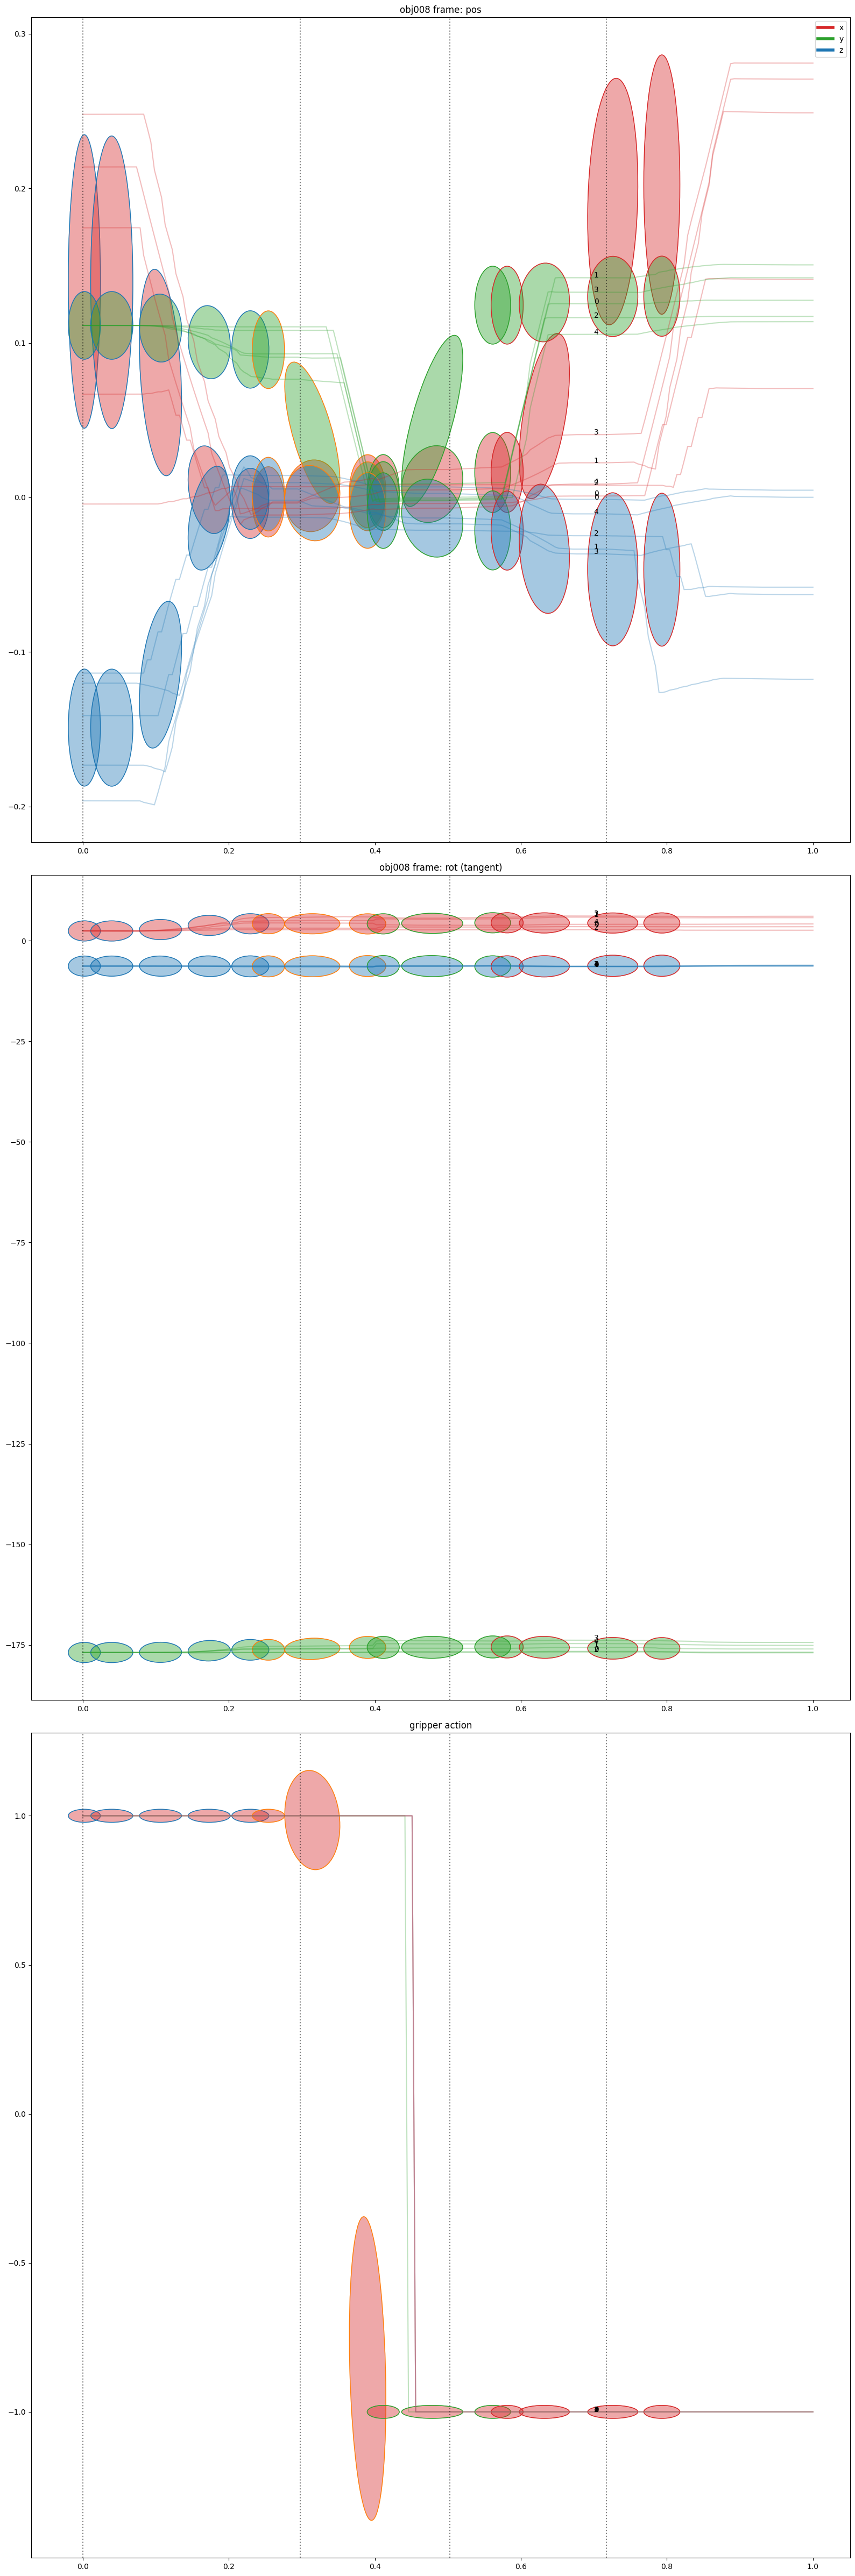

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 22:37:56.870 | INFO     |  Fitting AutoTPGMM
2025-08-05 22:37:56.870 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 22:37:56.886 | INFO     |  HMM EM ...
2025-08-05 22:37:56.893 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-05 22:37:56.966 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-05 22:38:12.257 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [3.71e-209, 2.83e-006, 5.66e-005, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 2.15e-241, 7.86e-035, ..., 1.78e-086, 1.13e-092,
          1.28e-096],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 5.05e-011, 4.21e-013,
          2.22e-014],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.93e-001,
          8.78e-001, 4.43e-001, 7.22e-002, 2.77e-003, 2.25e-005, 3.63e-008,
          1.13e-011, 6.61e-016, 6.97e-021, 3.81e-026, 4.62e-032, 2.91e-038,
          9.39e-045, 1.55e-051, 1.32e-058, 5.85e-066, 1.35e-073, 1.64e-081,
          1.04e-089, 9.75e-141, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
      

2025-08-05 22:38:26.359 | INFO     |  Did not specify time_based, deciding automatically.


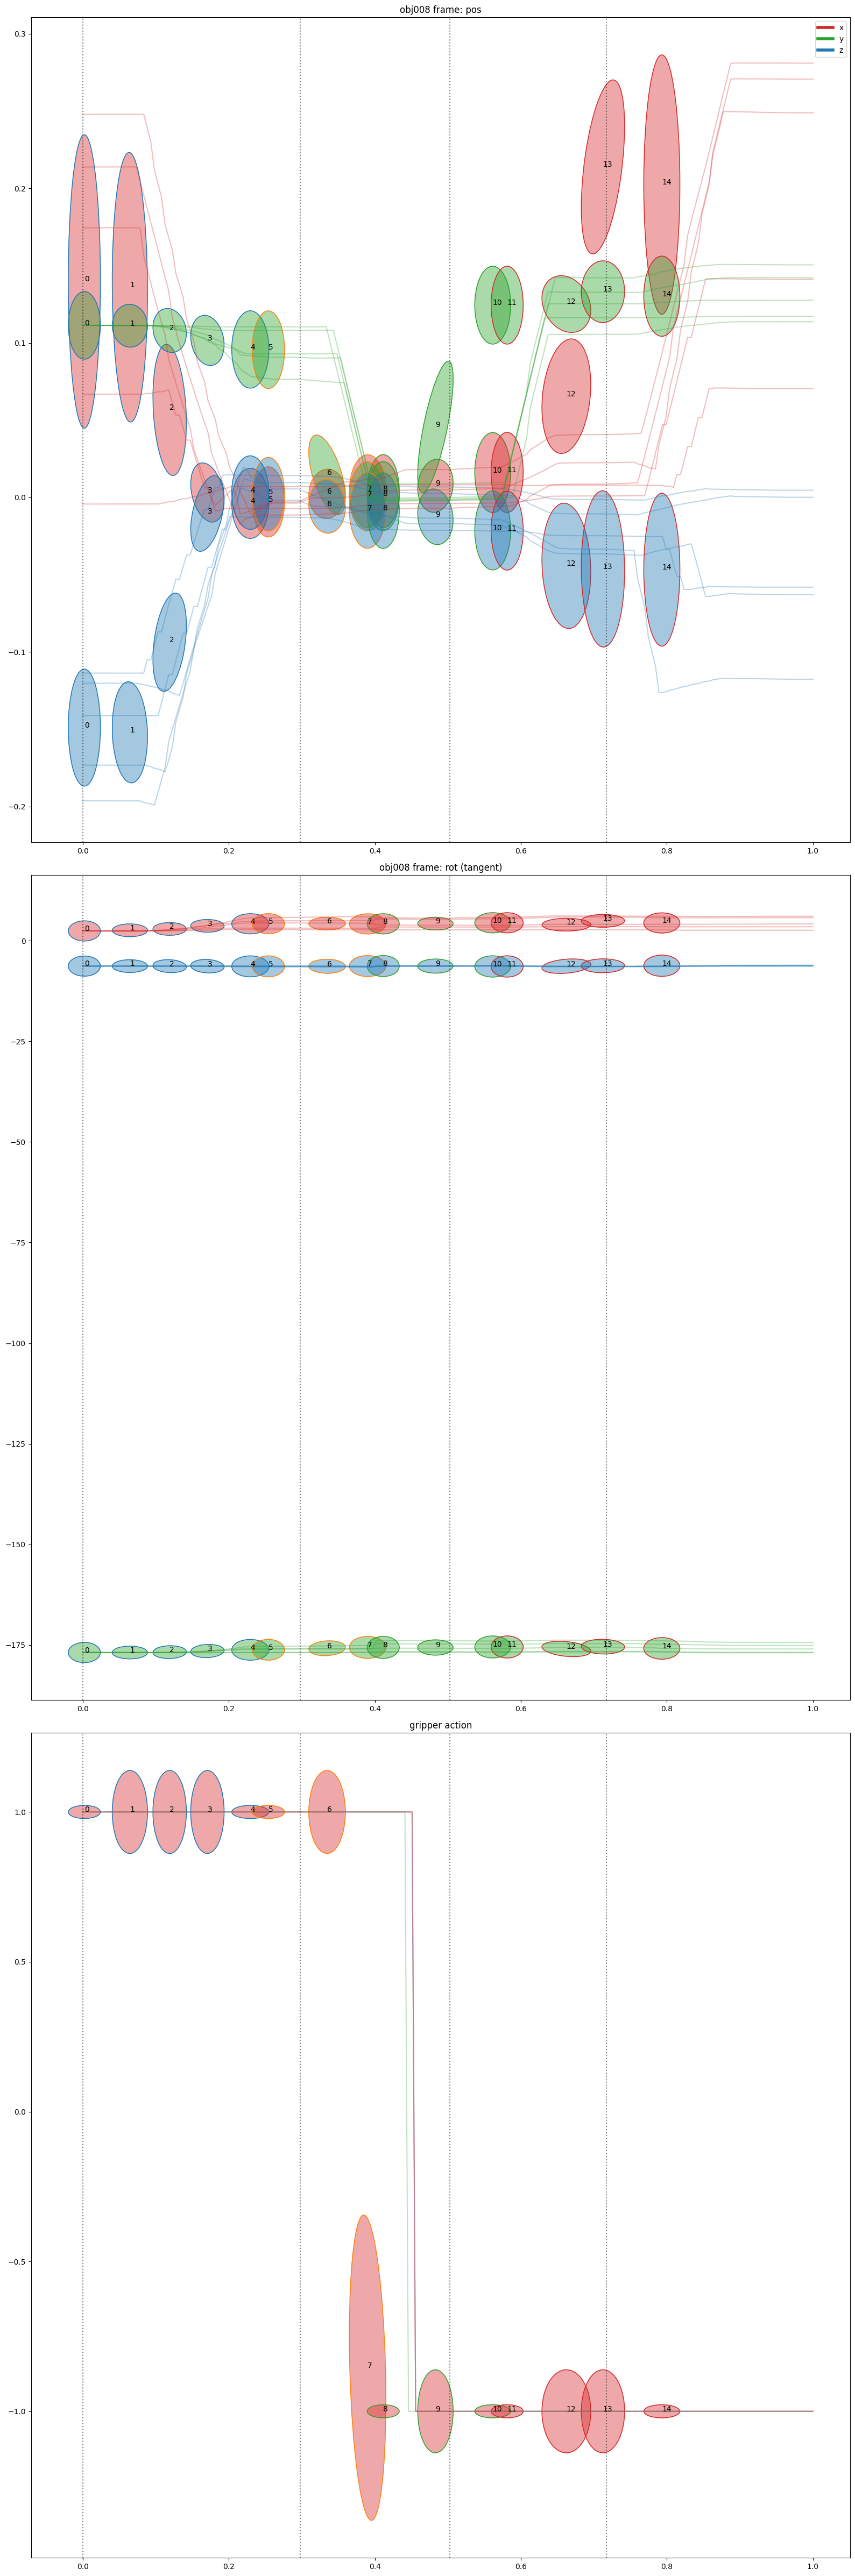

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

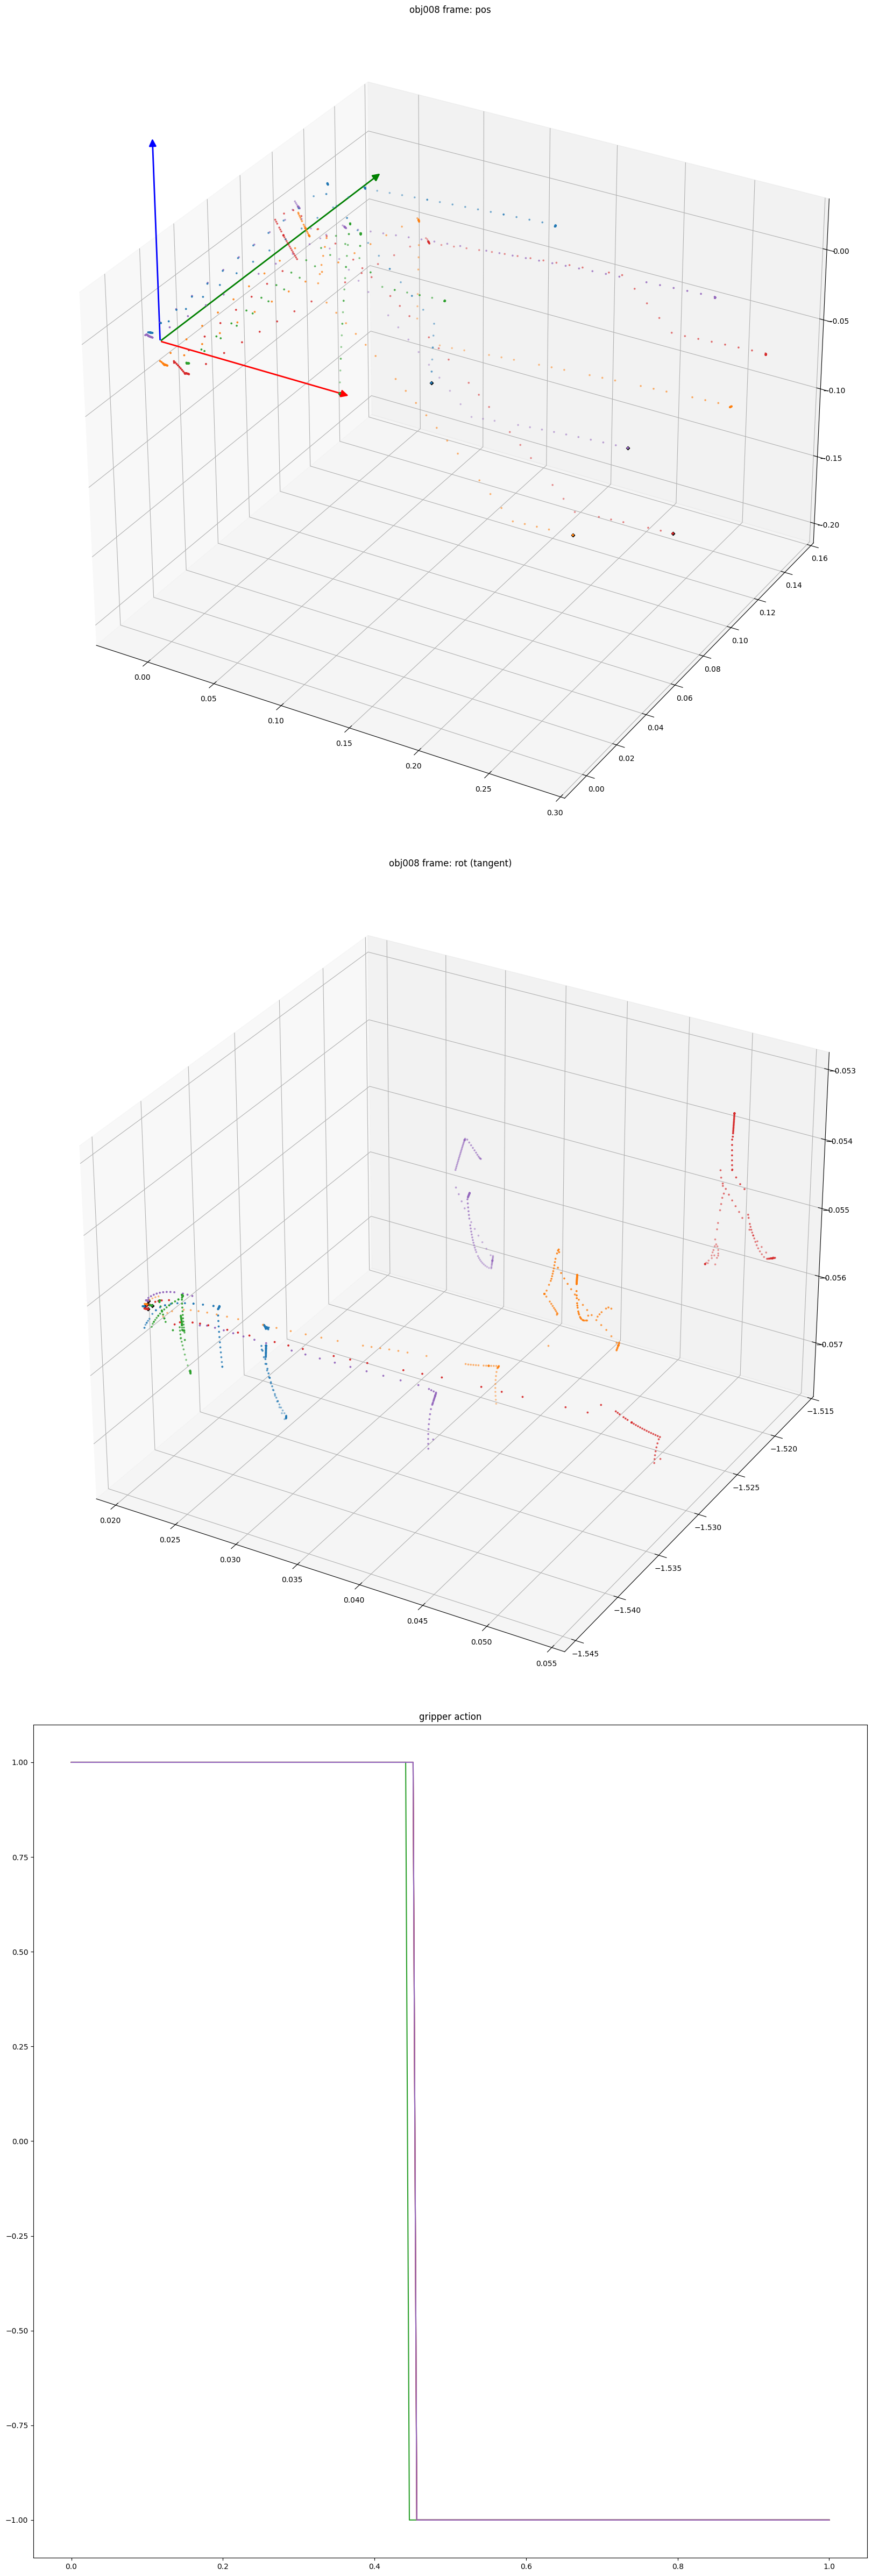

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

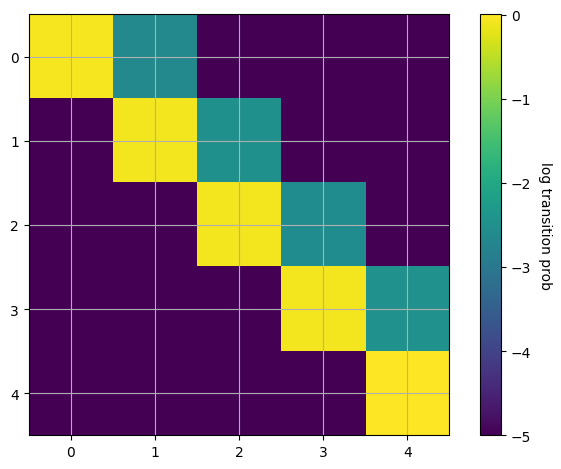

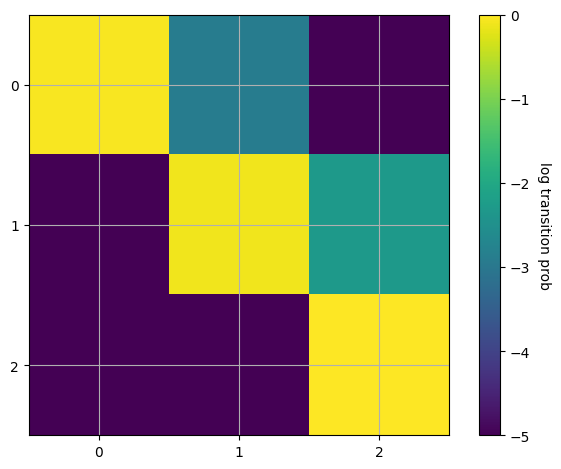

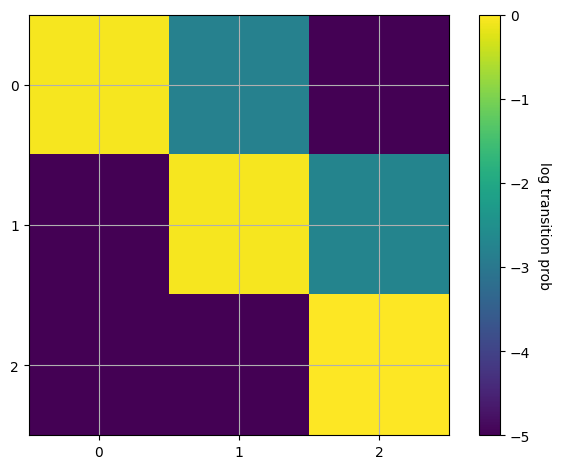

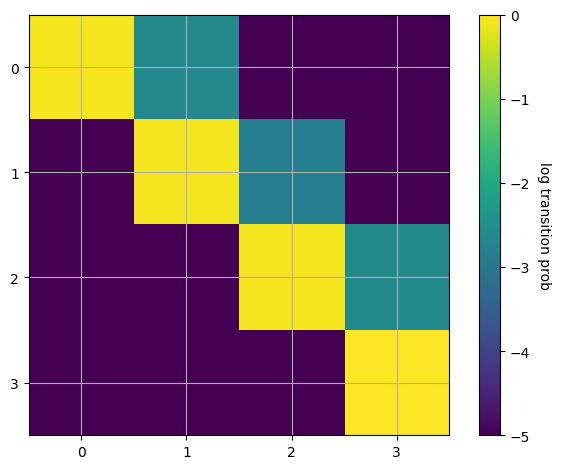

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-05 22:38:35.596 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 22:38:35.799 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-05 22:38:35.881 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-05 22:38:35.881 | INFO     |  Creating partial frame view of demos.
2025-08-05 22:38:35.911 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:38:35.969 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:38:36.060 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:38:36.144 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 22:38:36.216 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

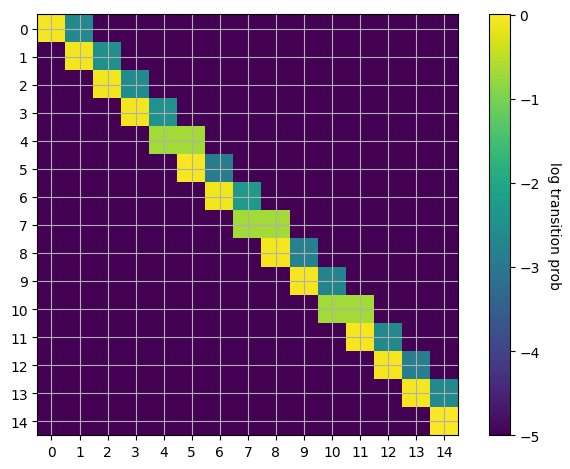

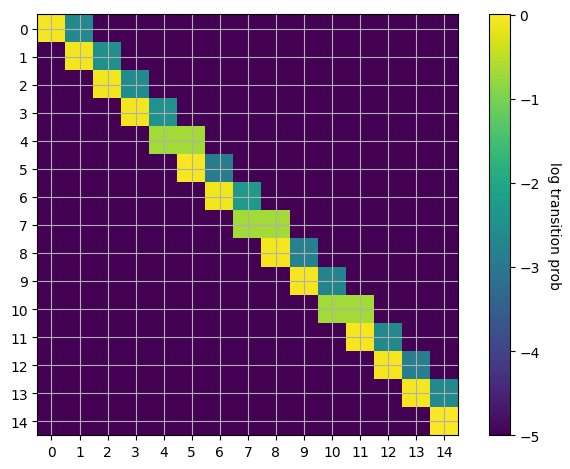

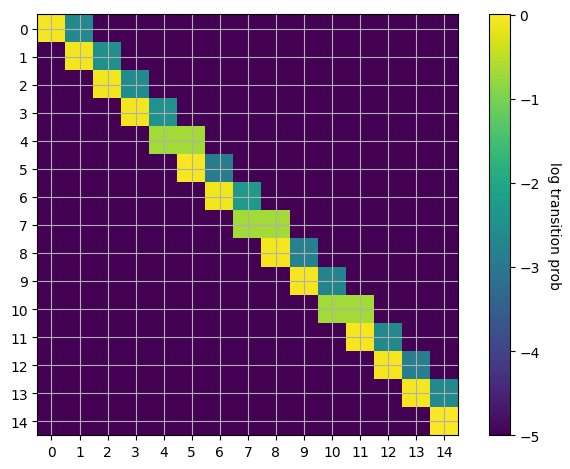

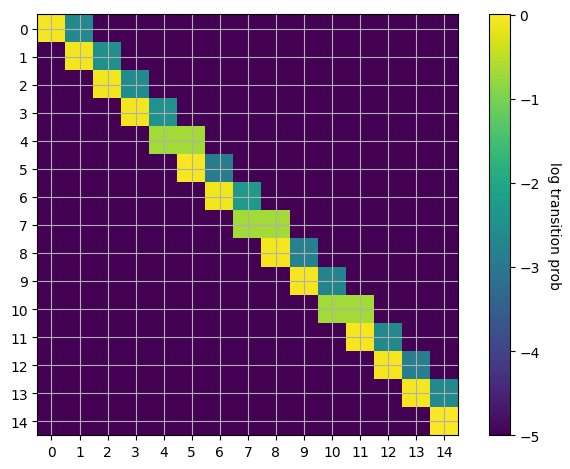

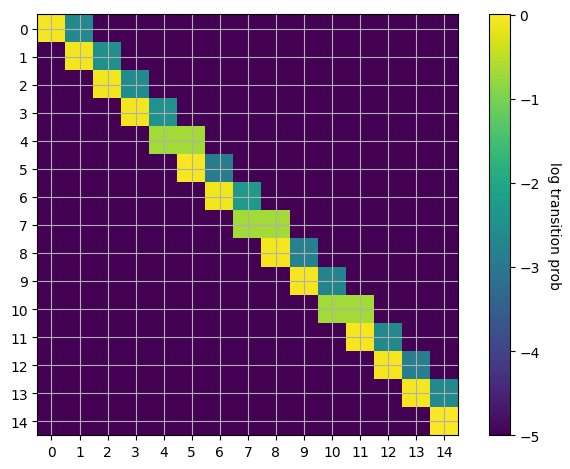

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 22:38:50.670 | INFO     |  Taking frame origins from demos.


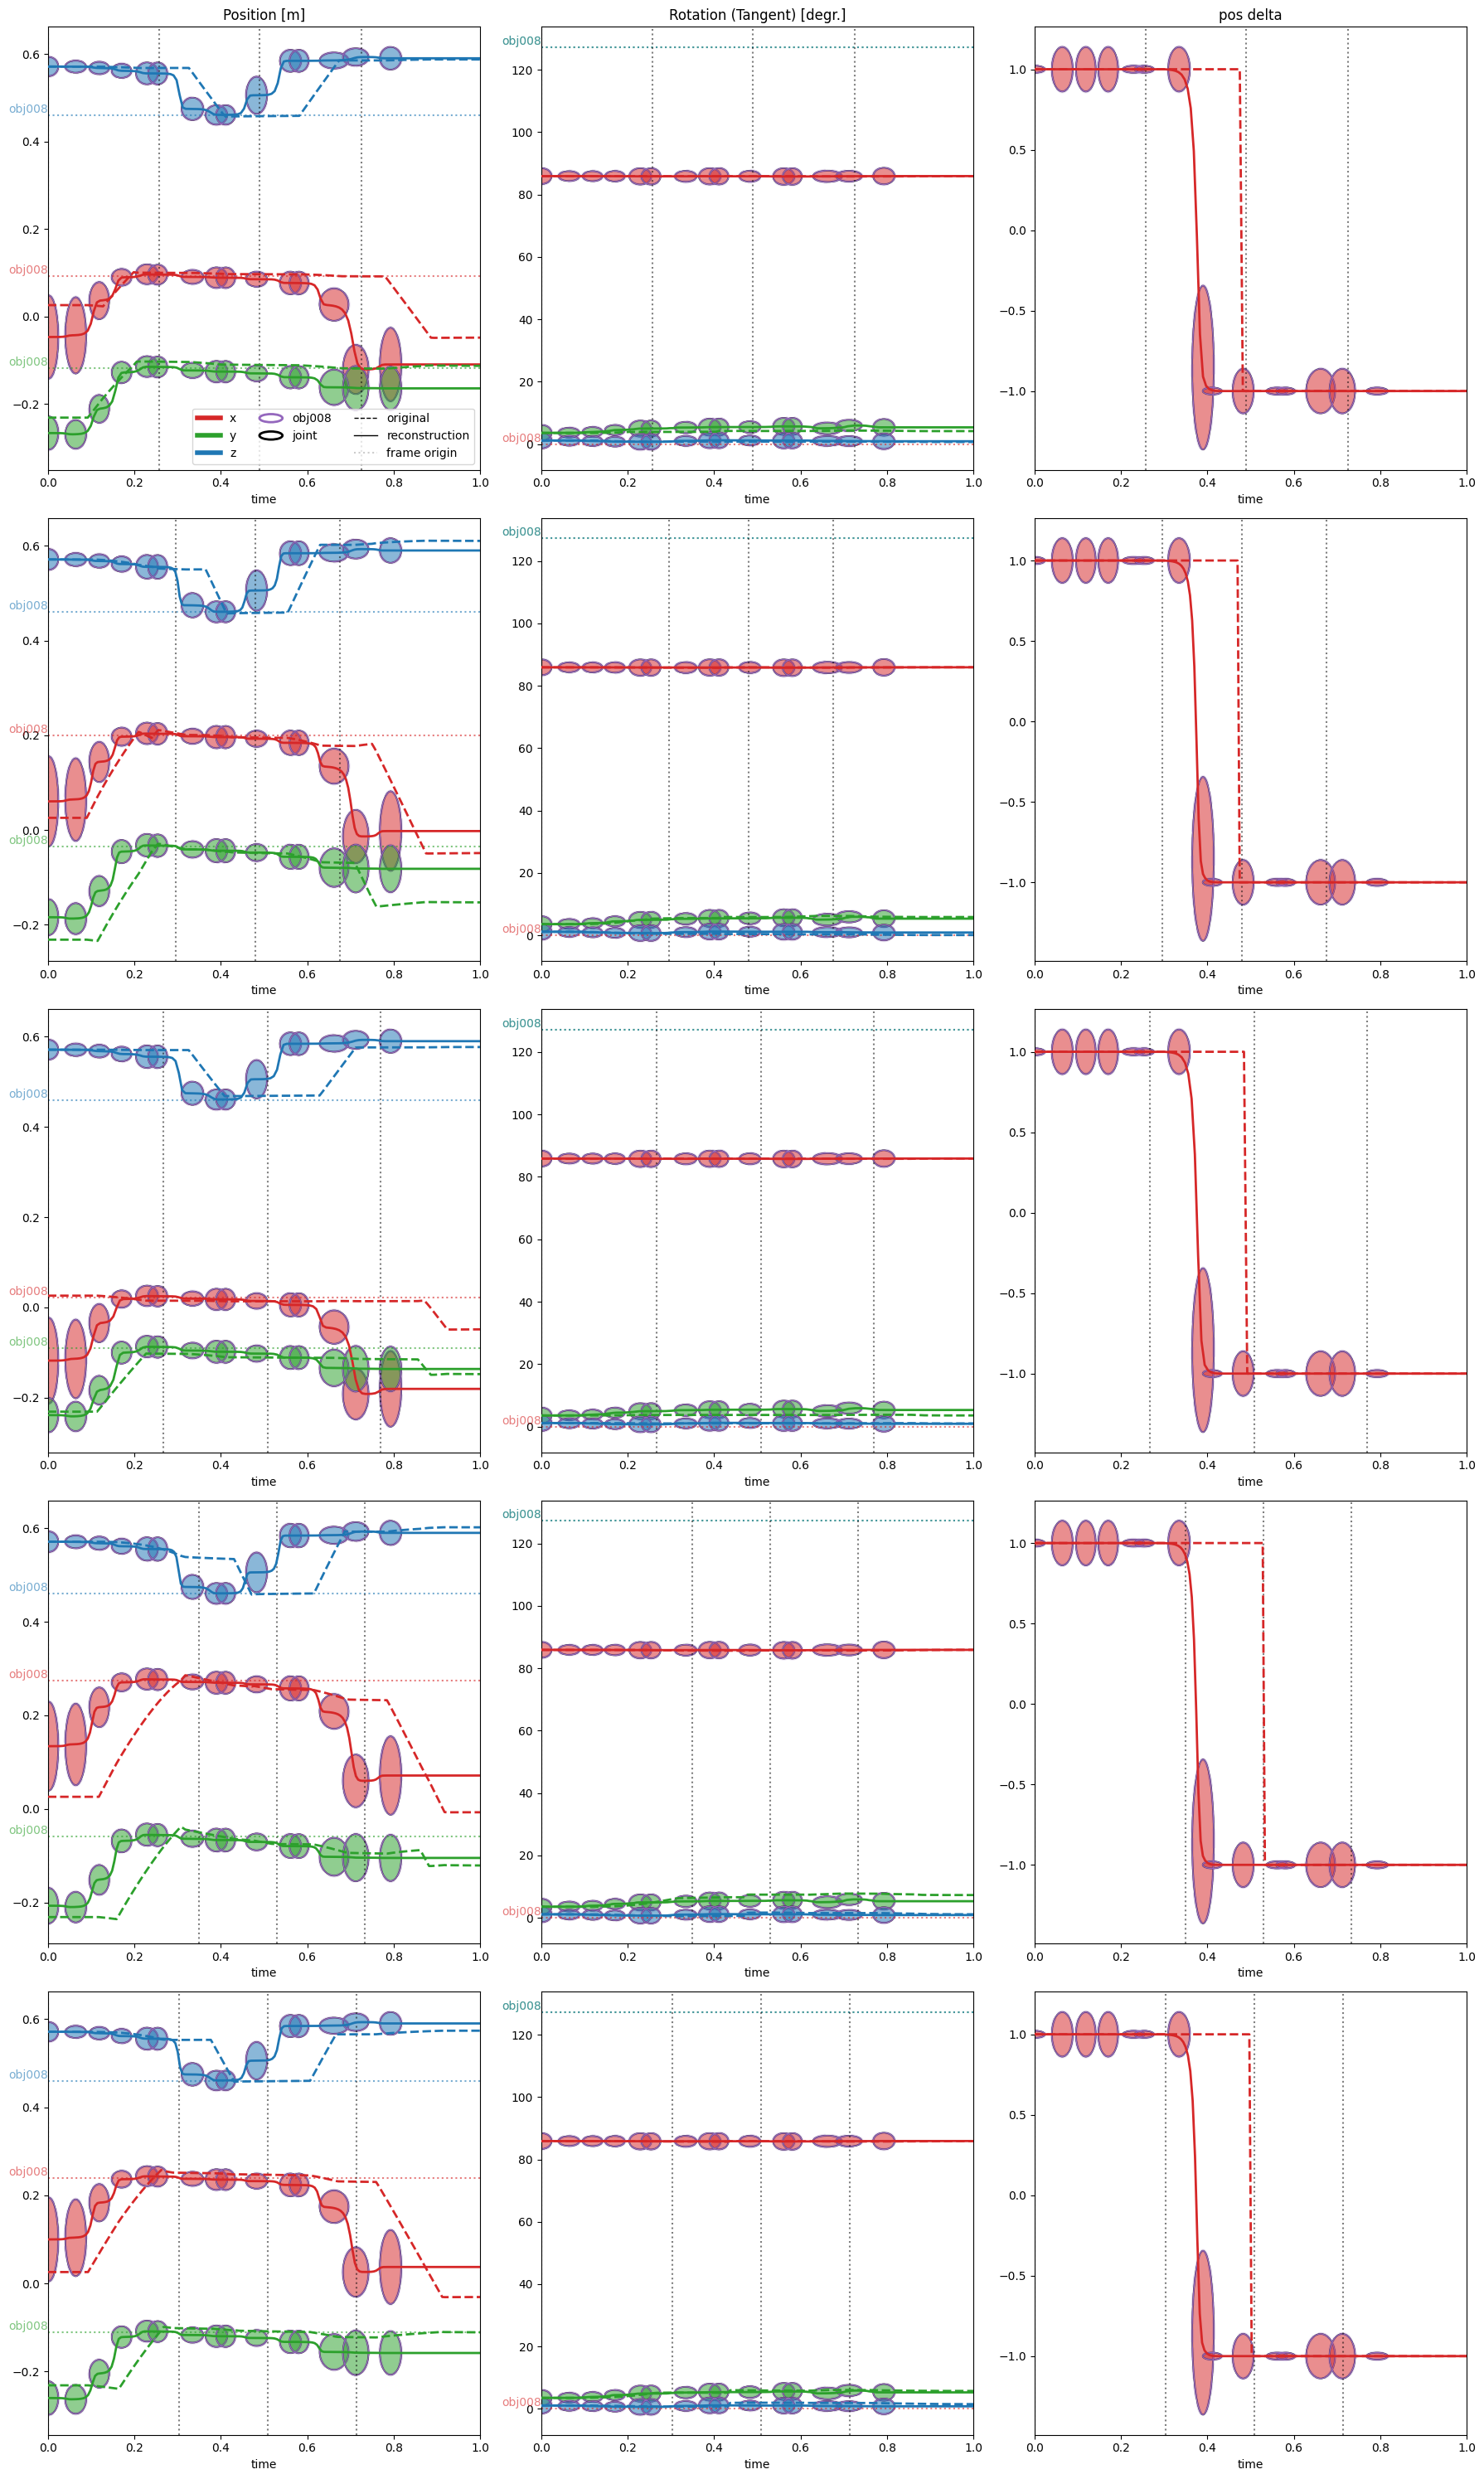

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range

: 